In [1]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless"

In [2]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'
    
my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C", 
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [3]:
# 🐝 Secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

! wandb login $secret_value_0

In [4]:
# === General Functions ===

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path, data_type="dataset"):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='Otto', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type=data_type)
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [5]:
# 🐝 Bonus: Cover Photo
run = wandb.init(project='RSNA_Breast_Cancer', name='CoverPhoto', config=CONFIG)
cover = plt.imread("/kaggle/input/rsna-breast-cancer-helper-data/DKn4ofz.png")
wandb.log({"cover": wandb.Image(cover)})
wandb.finish()

In [6]:
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")

# Get image path
# Example path: '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm'
base_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".dcm")
    
train["path"] = all_paths

In [7]:
print(clr.S+"Records gathered in Site 1:"+clr.E, train["site_id"].value_counts().values[0], "\n"+
      clr.S+"Records gathered in Site 2:"+clr.E, train["site_id"].value_counts().values[1])
print("-------------------------------------------------")
print(clr.S+"Total unique patients:"+clr.E, train["patient_id"].nunique())
print("-------------------------------------------------")
print(clr.S+"Total unique images:"+clr.E, train["image_id"].nunique())
print("-------------------------------------------------")
print(clr.S+"Statistics: Images per Patient"+clr.E)
print(train.groupby("patient_id")["image_id"].count().reset_index().describe()["image_id"])
print("-------------------------------------------------")
print(clr.S+"Image records count per laterality (R):"+clr.E, train["laterality"].value_counts().values[0], "\n"+
      clr.S+"Image records count per laterality (L):"+clr.E, train["laterality"].value_counts().values[1])
print("-------------------------------------------------")
print(clr.S+"Image records count per View:"+clr.E)
print(train["view"].value_counts())

In [8]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='view_sample', config=CONFIG)

In [9]:
def show_view(view_name, sample_size):
    
    if view_name != "LMO":
        # Get image info
        data = train[train["view"]==view_name].sample(sample_size, random_state=24)
        image_path = data["path"].to_list()

        # Plot
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        wandb_images = []

        for k, path in enumerate(image_path):
            axs[k].set_title(f"{k+1}. {view_name}", 
                             fontsize = 16, color = my_colors[0], weight='bold')

            img = pydicom.dcmread(path).pixel_array
            wandb_images.append(wandb.Image(img))
            axs[k].imshow(img, cmap="turbo")
            axs[k].axis("off")

        plt.tight_layout()
        plt.show()

        # 🐝 Log Image to W&B
        wandb.log({f"{view_name}": wandb_images})
    else:
        path = train[train["view"]=="LMO"]["path"].item()
        # Plot
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        wandb_images = []
        img = pydicom.dcmread(path).pixel_array
        wandb_images.append(wandb.Image(img))
        axs[0].imshow(img, cmap="turbo")
        axs[0].set_title(f"1. LMO", 
                         fontsize = 16, color = my_colors[0], weight='bold')
        axs[0].axis("off")
        axs[1].axis("off")
        axs[2].axis("off")
        axs[3].axis("off")
        axs[4].axis("off")

        plt.tight_layout()
        plt.show()
        
        wandb.log({f"LMO": wandb_images})

In [10]:
for view_name in train["view"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_view(view_name, sample_size=5)

In [11]:
wandb.finish()

In [12]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='age_hist', config=CONFIG)

In [13]:
# Plot
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(a=train["age"], rug=True, hist=False, 
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
             ax=a0)

a0.axvline(x=58, ls=":", lw=2, color="black")
a0.text(x=58.5, y=0.018, s="mean: 58", size=17, color="black", weight="bold")
a0.axvline(x=26, ls=":", lw=2, color="black")
a0.text(x=26.5, y=0.008, s="min: 26", size=17, color="black", weight="bold")
a0.axvline(x=89, ls=":", lw=2, color="black")
a0.text(x=84, y=0.037, s="max: 89", size=17, color="black", weight="bold")

sns.boxenplot(x=train["age"], ax=a1, color=my_colors[2])

plt.suptitle("Age Distribution", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [14]:
# 🐝 Log into dashboard
create_wandb_hist(x_data=train["age"], 
                  x_name="Age",
                  title="Age Distribution",
                  log="age_hist")

In [15]:
# Plot
f, (a0, a1) = plt.subplots(1, 2, figsize=(24, 12))
sns.distplot(a=train[train["cancer"]==0]["age"], rug=True, hist=False, 
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
             ax=a0)
a0.set_title("No Cancer Present", weight="bold", size=20)
a0.axvline(x=58, ls=":", lw=2, color="black")
a0.text(x=58.5, y=0.018, s="mean: 58", size=17, color="black", weight="bold")
a0.axvline(x=26, ls=":", lw=2, color="black")
a0.text(x=26.5, y=0.008, s="min: 26", size=17, color="black", weight="bold")
a0.axvline(x=89, ls=":", lw=2, color="black")
a0.text(x=79, y=0.037, s="max: 89", size=17, color="black", weight="bold")


sns.distplot(a=train[train["cancer"]==1]["age"], rug=True, hist=False, 
             rug_kws={"color": my_colors[2]},
             kde_kws={"color": my_colors[2], "lw": 5, "alpha": 0.7},
             ax=a1)
a1.set_title("Cancer Present", weight="bold", size=20)
a1.axvline(x=63, ls=":", lw=2, color="black")
a1.text(x=63.5, y=0.018, s="mean: 63", size=17, color="black", weight="bold")
a1.axvline(x=38, ls=":", lw=2, color="black")
a1.text(x=38.5, y=0.008, s="min: 38", size=17, color="black", weight="bold")
a1.axvline(x=89, ls=":", lw=2, color="black")
a1.text(x=79, y=0.037, s="max: 89", size=17, color="black", weight="bold")


plt.suptitle("Age Distribution", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [16]:
# 🐝 Log into dashboard
create_wandb_hist(x_data=train[train["cancer"]==1]["age"], 
                  x_name="Age",
                  title="Age Distribution - patients with cancer",
                  log="age_hist_cancer")

In [17]:
wandb.finish()

In [18]:
# 🐝 New Experiment
run = wandb.init(project='RSNA_Breast_Cancer', name='implant_sample', config=CONFIG)

In [19]:
def show_images(col, col_flag, sample_size, cancer_flag=0):
    
    # Get image info
    data = train[train[col]==col_flag].sample(sample_size, random_state=24)
    if cancer_flag==1:
        data = train[train.cancer==1]
        data = data[data[col]==col_flag].sample(sample_size, random_state=24)
    image_path = data["path"].to_list()

    # Plot
    fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
    axs = axs.flatten()
    wandb_images = []

    for k, path in enumerate(image_path):
        axs[k].set_title(f"{k+1}. {col_flag}", 
                         fontsize = 14, color = my_colors[0], weight='bold')

        img = pydicom.dcmread(path).pixel_array
        wandb_images.append(wandb.Image(img))
        axs[k].imshow(img, cmap="turbo")
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

    # 🐝 Log Image to W&B
    wandb.log({f"{col}_{col_flag}": wandb_images})

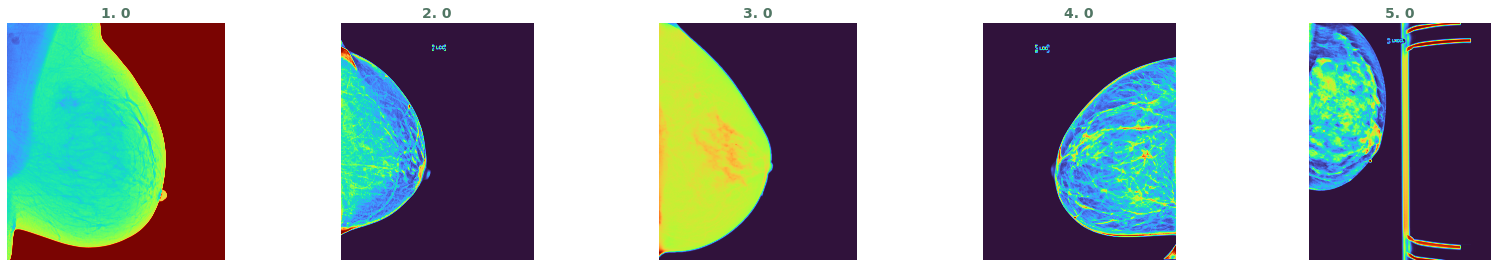

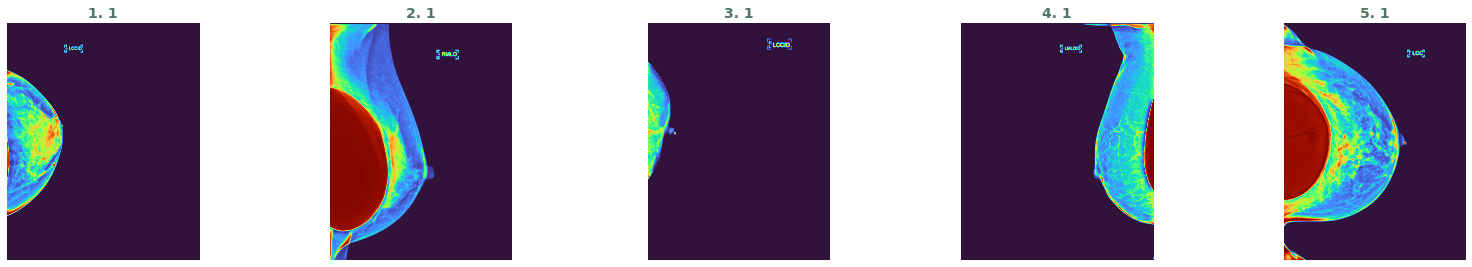

In [20]:
print(clr.S+"Records with no implants:"+clr.E, train["implant"].value_counts().values[0], "\n"+
      clr.S+"Records with implants:"+clr.E, train["implant"].value_counts().values[1], "\n")

for implant_flag in train["implant"].unique().tolist():
    # Custom function to prin images & log into 🐝W&B
    show_images(col="implant", col_flag=implant_flag, sample_size=5)

In [21]:
wandb.finish()